<a href="https://colab.research.google.com/github/stanislavfort/initialization-optimum-connectivity-experiments/blob/main/nicer_init_to_optimum_landscape_cuts_in_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization to optimum landscape cuts in JAX

In this Colab I train several models from different initializations and then try walking from every initialization to every optimum in the weight space and monitoring accuracy and loss along the way. I also visualization loss and accuracy on 2D sections of the weight space defined by 2 initializations and 1 optimum, and 2 optima and 1 initialization.

# Loading libraries

In [1]:
!pip install flax

     |████████████████████████████████| 163kB 13.8MB/s 


# Libraries

In [2]:
import jax

jax.config.enable_omnistaging()

import flax

import numpy as onp #original numpy
import jax.numpy as jnp #jax numpy

import tensorflow_datasets as tfds

from jax.experimental import optimizers
from flax import nn

import math
import time

import jax.ops as ops
import jax.random as random

import matplotlib.pyplot as plt

# Plotting style

In [3]:
import matplotlib as mpl
import seaborn as sns
sns.set_style("ticks")

mpl.style.use('seaborn-notebook')
mpl.rcParams.update({'font.size': 14, 'lines.linewidth': 2, 'figure.figsize': (6, 6/1.61)})
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['lines.marker'] = None
mpl.rcParams['axes.grid'] = True
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

DEFAULT_FONTSIZE = 13
mpl.rcParams.update({'font.size': DEFAULT_FONTSIZE, 'lines.linewidth': 2, 
                    'legend.fontsize': DEFAULT_FONTSIZE, 'axes.labelsize': DEFAULT_FONTSIZE, 
                    'xtick.labelsize': DEFAULT_FONTSIZE, 'ytick.labelsize': DEFAULT_FONTSIZE, 'figure.figsize': (7, 7.0/1.4)})

markers_list = ["o","x","D","*","^"]


plt.rcParams['svg.fonttype'] = 'none'

# Example architectures

## Simple CNN architecture

In [4]:
class CNN(flax.nn.Module):
  def apply(self, x, classes = 10, channels = [32,64,64,128], train=False):

    for features in channels:
      x = flax.nn.Conv(x, features=features, kernel_size=(3, 3))
      x = flax.nn.relu(x)
      x = flax.nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))

    #getting it flat
    x = x.reshape((x.shape[0], -1))

    # final layer
    x = flax.nn.Dense(x, features=classes)
    x = flax.nn.log_softmax(x)
    return x

## ResNets

In [5]:
class KerasResNets(flax.nn.Module): #inspired by the Keras examples and rewritten to JAX
  
  def apply(self, x, train=True, depth = (3*6+2), num_classes=10, use_batch_norm=True):

    def resnet_layer(inputs,
                     num_filters=16,
                     kernel_size=3,
                     strides=1,
                     activation="relu",
                     conv_first=True,
                     train=True,
                     ):
      
      if use_batch_norm:
        batch_norm = nn.BatchNorm.partial(use_running_average=not train,momentum=0.9, epsilon=1e-5)
      
      if activation == "relu":
        f = flax.nn.relu
      elif activation is None:
        f = lambda q: q

      a = inputs
      if conv_first:
        a = flax.nn.Conv(a, features=num_filters,strides=(strides,strides),padding="SAME",kernel_size=(3, 3))
        if use_batch_norm:
          a = batch_norm(a)
        a = f(a)
      else:
        if use_batch_norm:
          a = batch_norm(a)
        a = f(a)
        a = flax.nn.Conv(a, features=num_filters,strides=(strides,strides),padding="SAME",kernel_size=(3, 3))
      
      return a

    if (depth - 2) % 6 != 0:
          raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
      
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = x
    x = resnet_layer(inputs=inputs, train=train)

    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                            num_filters=num_filters,
                            strides=strides, train=train)
            
            y = resnet_layer(inputs=y,
                            num_filters=num_filters,
                            activation=None, train=train)
            
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                num_filters=num_filters,
                                kernel_size=1,
                                strides=strides,
                                activation=None, train=train)
                
            x = x+y
            x = flax.nn.relu(x)
        num_filters *= 2

    x = flax.nn.avg_pool(x, window_shape=(8, 8), strides=(8, 8))

    x = x.reshape((x.shape[0], -1))
    x = flax.nn.Dense(x, features=num_classes)
    x = flax.nn.log_softmax(x)

    return x



# Choosing the architecture

In [6]:
classes = 10 #has to match the number of classes of the chosen dataset

#choose on of the two examples, the default is ResNet
# model_choice = "ResNet"
model_choice = "SimpleCNN"

if model_choice == "ResNet":
  model_to_use = KerasResNets.partial(
    num_classes = classes,
    use_batch_norm = True,
  )
  model_name = "ResNetBN"

elif model_choice == "SimpleCNN":
  model_to_use = CNN.partial(
    classes = classes,
    channels = [32,64,64,128],
  )
  model_name = "SimpleCNN"

else:
  print("Architecture "+str(model_choice)+" not found!")
  assert False

# Utils

In [7]:
def np_onehot(labels,classes=10):
  return onp.eye(classes)[labels]

In [8]:
from flax.training import lr_schedule

# def make_lr_fun(base_lr, steps_per_epoch):  
#   return lr_schedule.create_stepped_learning_rate_schedule(base_lr, steps_per_epoch,[[80, 0.01], [120, 0.001]])

# default_LR = 0.1
# learning_rate_fn = make_lr_fun(default_LR, int(float(50000)/float(128))) # the standard ResNet training schedule (>91% test after 200 epochs)

def make_lr_fun(base_lr, steps_per_epoch):  
  return lr_schedule.create_stepped_learning_rate_schedule(base_lr, steps_per_epoch,[[40, 0.01], [60, 0.001]])

default_LR = 0.1
learning_rate_fn = make_lr_fun(default_LR, int(float(50000)/float(128))) # the standard ResNet training schedule (>91% test after 200 epochs)

@jax.vmap
def cross_entropy_loss(logits, onehot):
  return -jnp.sum(logits*onehot)

def compute_metrics(logits, onehot):
  loss = jnp.mean(cross_entropy_loss(logits, onehot))
  accuracy = jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(onehot, -1))
  return {'loss': loss, 'accuracy': accuracy}

@jax.jit
def train_step(step, optimizer, batch, state):

  def loss_fn(model):

    with flax.nn.stateful(state) as new_state: #to update the state
      logits = model(batch['image'])

    loss = jnp.mean(cross_entropy_loss(
        logits, batch['onehot']))
    
    params = model.params

    #for L2 penalty on the loss
    weight_penalty_params = jax.tree_leaves(params)
    weight_decay = 1e-4
    weight_l2 = sum([jnp.sum(x ** 2)
                      for x in weight_penalty_params
                      if x.ndim > 2])
    weight_penalty = weight_decay * 0.5 * weight_l2

    return loss + weight_penalty, new_state

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

  (_, new_state), grad = grad_fn(optimizer.target)

  new_optimizer = optimizer.apply_gradient(grad, learning_rate=learning_rate_fn(step))

  return new_optimizer, new_state

@jax.jit
def eval(model, eval_ds, state):
  with flax.nn.stateful(state, mutable=False):
    logits = model(eval_ds['image'], train=False)

  return compute_metrics(logits, eval_ds['onehot'])


def normal_loss(params, batch, train=True):
  logits = model_to_use.call(params, batch['image'], train = train)

  logits = jax.nn.log_softmax(logits)

  loss = jnp.mean(cross_entropy_loss(logits, batch['onehot']))
  return loss

def normal_accuracy(params,batch, train=True):
  logits = model_to_use.call(params, batch['image'], train = train)

  logits = jax.nn.log_softmax(logits)

  return jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(batch['onehot'],axis=-1))


In [9]:
def normal_loss_and_accuracy(params,batch, train=True, local_batch_size = 128):

  N = len(batch["image"])
  its = int(onp.ceil(float(N)/float(local_batch_size)))

  accs_weighted = 0.0
  losses_weighted = 0.0
  N_summed = 0.0 #should just be N in the end

  for it in range(its):
    i1 = it*local_batch_size
    i2 = min([(it+1)*local_batch_size,N])
    
    logits = model_to_use.call(params, batch['image'][i1:i2], train = train)
    logits = jax.nn.log_softmax(logits)

    loss_now = jnp.mean(cross_entropy_loss(logits, batch['onehot'][i1:i2]))
    acc_now = jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(batch['onehot'][i1:i2],axis=-1))

    accs_weighted += (i2-i1)*acc_now
    losses_weighted += (i2-i1)*loss_now
    N_summed += i2-i1

  return losses_weighted/N_summed,accs_weighted/N_summed


# Dataset

## Choosing dataset

In [10]:
dataset_choice = "CIFAR10"
# dataset_choice = "CIFAR100"

train_fraction = None
consistently_randomize_ys = False

## Loading dataset

In [11]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10,cifar100

subtract_pixel_mean = True

if dataset_choice == "CIFAR10":
  classes = 10
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
elif dataset_choice == "CIFAR100":
  classes = 100
  (x_train, y_train), (x_test, y_test) = cifar100.load_data()

y_train = y_train.reshape([-1])
y_test = y_test.reshape([-1])


if train_fraction is None:
  pass
else:
  n_to_keep = int(onp.ceil(float(len(x_train))*train_fraction))
  ids_to_keep = onp.random.choice(range(len(x_train)),(n_to_keep),replace = False)
  x_train = x_train[ids_to_keep]
  y_train = y_train[ids_to_keep]
  print("train_fraction",train_fraction)
  print("x_train",x_train.shape)
  print("y_train",y_train.shape)


#consistent randomization of labels
if consistently_randomize_ys:
  print("LABEL RANDOMIZATION IS ON!!")
  y_train = onp.random.choice(range(classes),y_train.shape,replace=True)
  y_test = onp.random.choice(range(classes),y_test.shape,replace=True)

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = onp.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

orig_x_train = onp.array(x_train)
orig_y_train = onp.array(y_train)

170500096/170498071 [==============================] - 6s 0us/step


In [12]:
N_train = len(x_train)
N_test = len(x_test)

train_ds = {
  'image': orig_x_train.astype(jnp.float32),
  'onehot': np_onehot(orig_y_train.astype(jnp.int32),classes),
}

test_ds = {
  'image': x_test.astype(jnp.float32),
  'onehot': np_onehot(y_test.astype(jnp.int32),classes)
}

# Model training loop

## Training setup

In [13]:
points_to_collect = 3 #how many times to train
epochs = 5 #5 #how many epochs for to train

batch_size = 128#//4 

## The training loop

In [14]:
train_ds["onehot"].shape

(50000, 10)

In [15]:
ts = []

# collecting train params and states
params_collected_by_iteration = [[] for _ in range(points_to_collect)]
states_collected_by_iteration = [[] for _ in range(points_to_collect)]

#which iterations to save the params at
def it_to_save_fn(it):
  return (it % 100 == 0) or (it in [0,1,2,3,4,5,6,7,8,9,10]) or ((10<it<100) and (it % 10 == 0))

for point_id in range(points_to_collect):

  with flax.nn.stateful() as init_state_raw:
    _, initial_params = model_to_use.init_by_shape(jax.random.PRNGKey(point_id+97432), [((128, 32, 32, 3), jnp.float32)])
    model = flax.nn.Model(model_to_use, initial_params)
    init_state = init_state_raw

  state = init_state # for the batch norm params

  optimizer = flax.optim.Momentum(learning_rate=0.1, beta=0.9).create(model) #the LR doesn't matter, it changes on every update based on the train fn

  print("Number of params = "+str(onp.sum([onp.prod(x.shape) for x in jax.tree_flatten(initial_params)[0]])))
    
  params_collected_by_iteration[point_id].append((None,initial_params))
  states_collected_by_iteration[point_id].append((None,state))

  total_it = -1
  t1 = time.time()

  while True:

    #getting a random batch
    batch_ids = onp.random.choice(range(len(train_ds["image"])),(batch_size),replace = False)
    batch = {
      "image": train_ds["image"][batch_ids],
      "onehot": train_ds["onehot"][batch_ids],
    }

    total_it = total_it + 1

    if total_it / (len(x_train)/float(batch_size)) > epochs:
      break

    #getting the update step
    optimizer,state = train_step(total_it, optimizer, batch, state)

    #getting the params out
    params_now = optimizer.target.params

    if it_to_save_fn(total_it): #collecting parameters as training progresses
      params_collected_by_iteration[point_id].append((total_it,params_now))
      states_collected_by_iteration[point_id].append((total_it,state))

    #batch loss and acc
    metrics = eval(optimizer.target, batch, state)
    loss_out = metrics["loss"]
    accuracy_out = metrics["accuracy"]

    e_float = total_it / (len(x_train)/float(batch_size))

    #looking at test set once every epoch
    if (total_it % int(len(x_train)/float(batch_size))) in [0]:  
      #test verification

      #doing the BN averaing on the test
      test_loss_out_testBN = normal_loss(params_now,test_ds)
      test_accuracy_out_testBN = normal_accuracy(params_now,test_ds)

      t2 = time.time()
      if total_it > 0:
        ts.append(t2-t1)
        t_rem_str = str(int(onp.mean(ts)*points_to_collect*epochs - onp.sum(ts)))
      else:
        t_rem_str = "TBD" 
      t1 = time.time()


      print("e="+str(e_float)+
            " it="+str(total_it)+
            " train loss="+str(loss_out)+
            " train acc="+str(accuracy_out)+
            " test loss="+str(test_loss_out_testBN)+
            " test acc="+str(test_accuracy_out_testBN)+
            " t_rem="+str(t_rem_str)
            )
      


Number of params = 135306
e=0.0 it=0 train loss=2.291415 train acc=0.1953125 test loss=2.2973344 test acc=0.1356 t_rem=TBD
e=0.9984 it=390 train loss=1.3203537 train acc=0.578125 test loss=1.3213379 test acc=0.51780003 t_rem=78
e=1.9968 it=780 train loss=1.1742666 train acc=0.5625 test loss=1.129711 test acc=0.5957 t_rem=71
e=2.9952 it=1170 train loss=0.9100462 train acc=0.6328125 test loss=1.0400125 test acc=0.63240004 t_rem=65
e=3.9936 it=1560 train loss=0.7169337 train acc=0.7421875 test loss=0.91639876 test acc=0.6808 t_rem=59
e=4.992 it=1950 train loss=0.6502085 train acc=0.78125 test loss=0.8585927 test acc=0.70320004 t_rem=53
Number of params = 135306
e=0.0 it=0 train loss=2.2989845 train acc=0.1328125 test loss=2.3031006 test acc=0.099400006 t_rem=TBD
e=0.9984 it=390 train loss=1.2899712 train acc=0.4921875 test loss=1.3599719 test acc=0.5011 t_rem=47
e=1.9968 it=780 train loss=0.91187924 train acc=0.703125 test loss=1.1326523 test acc=0.6065 t_rem=42
e=2.9952 it=1170 train los

# Weight space utils

In [16]:
from functools import partial
from jax.tree_util import tree_multimap

@partial(partial, tree_multimap)
def raw_tree_norm_squared(x):
  return x**2.0

def tree_norm(x):
  #return onp.array(jnp.sqrt(raw_tree_norm_squared(x)[0])).astype(onp.float32)
  return onp.sqrt(onp.sum(onp.concatenate([q.reshape([-1]) for q in jax.tree_leaves(raw_tree_norm_squared(x))])))

@partial(partial, tree_multimap)
def tree_leaf_sum(x):
  return jnp.sum(x)


def tree_norm_squared(x):
  #return onp.array(jnp.sqrt(raw_tree_norm_squared(x)[0])).astype(onp.float32)
  return raw_tree_norm_squared(x)

# @partial(partial, tree_multimap)
# def multiply_tree(t,factor):
#   return factor*t

def multiply_tree(factor,t):
  fn = lambda leaf: factor*leaf
  return tree_multimap(fn,t)

@partial(partial, tree_multimap)
def add_trees(t1,t2):
  return t1+t2

@partial(partial, tree_multimap)
def multiply_trees(t1,t2):
  return t1*t2

def dot_trees(t1,t2):
  return onp.sum(onp.concatenate([q.reshape([-1]) for q in jax.tree_leaves(multiply_trees(t1,t2))]))

def linear_combine_trees(f1,t1,f2,t2):
  return add_trees(multiply_tree(f1,t1),multiply_tree(f2,t2))

@partial(partial, tree_multimap)
def zero_tree(t1):
  return 0.0

def flatten_tree_into_vector(t):
  return onp.concatenate([q.reshape([-1]) for q in jax.tree_leaves(t)])


# Accuracy, loss and weight L2 distance for runs

In [17]:
epochs_list = [[] for _ in range(points_to_collect)]

test_accs_list = [[] for _ in range(points_to_collect)]
test_losses_list = [[] for _ in range(points_to_collect)]
train_accs_list = [[] for _ in range(points_to_collect)]
train_losses_list = [[] for _ in range(points_to_collect)]

distance_from_init_list = [[] for _ in range(points_to_collect)]

for point_id in range(points_to_collect):

  init_params_now = params_collected_by_iteration[point_id][0][1]

  for i,(it_now,params_now) in enumerate(params_collected_by_iteration[point_id][::1]):

    params_diff = linear_combine_trees(1.0,params_now,-1.0,init_params_now)
    param_distance_from_init = tree_norm(params_diff)

    distance_from_init_list[point_id].append(param_distance_from_init)

    if it_now is None:
      epoch_nice = 0.0
    else:
      epoch_nice = it_now*batch_size / 50000.0

    print(point_id,epoch_nice)

    epochs_list[point_id].append(epoch_nice)  

    test_loss_now,test_acc_now = normal_loss_and_accuracy(params_now,test_ds,True,5000)
    test_accs_list[point_id].append(test_acc_now)    
    test_losses_list[point_id].append(test_loss_now)    

    train_loss_now,train_acc_now = normal_loss_and_accuracy(params_now,train_ds,True,5000)
    train_accs_list[point_id].append(train_acc_now)    
    train_losses_list[point_id].append(train_loss_now)    


0 0.0
0 0.0
0 0.00256
0 0.00512
0 0.00768
0 0.01024
0 0.0128
0 0.01536
0 0.01792
0 0.02048
0 0.02304
0 0.0256
0 0.0512
0 0.0768
0 0.1024
0 0.128
0 0.1536
0 0.1792
0 0.2048
0 0.2304
0 0.256
0 0.512
0 0.768
0 1.024
0 1.28
0 1.536
0 1.792
0 2.048
0 2.304
0 2.56
0 2.816
0 3.072
0 3.328
0 3.584
0 3.84
0 4.096
0 4.352
0 4.608
0 4.864
1 0.0
1 0.0
1 0.00256
1 0.00512
1 0.00768
1 0.01024
1 0.0128
1 0.01536
1 0.01792
1 0.02048
1 0.02304
1 0.0256
1 0.0512
1 0.0768
1 0.1024
1 0.128
1 0.1536
1 0.1792
1 0.2048
1 0.2304
1 0.256
1 0.512
1 0.768
1 1.024
1 1.28
1 1.536
1 1.792
1 2.048
1 2.304
1 2.56
1 2.816
1 3.072
1 3.328
1 3.584
1 3.84
1 4.096
1 4.352
1 4.608
1 4.864
2 0.0
2 0.0
2 0.00256
2 0.00512
2 0.00768
2 0.01024
2 0.0128
2 0.01536
2 0.01792
2 0.02048
2 0.02304
2 0.0256
2 0.0512
2 0.0768
2 0.1024
2 0.128
2 0.1536
2 0.1792
2 0.2048
2 0.2304
2 0.256
2 0.512
2 0.768
2 1.024
2 1.28
2 1.536
2 1.792
2 2.048
2 2.304
2 2.56
2 2.816
2 3.072
2 3.328
2 3.584
2 3.84
2 4.096
2 4.352
2 4.608
2 4.864


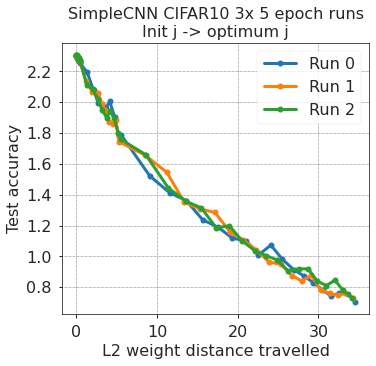

In [18]:
plt.figure(figsize = (5.5,5))

title = model_name+" "+dataset_choice+" "+str(points_to_collect)+"x "+str(epochs)+" epoch runs\n"
title = title+"Init j -> optimum j"

plt.title(title,fontsize = 16)

for point_id in range(points_to_collect):
  plt.plot(distance_from_init_list[point_id],train_losses_list[point_id],linewidth = 3,label = "Run "+str(point_id),marker = "o")

plt.xticks(fontsize = 16) 
plt.yticks(fontsize = 16) 

plt.xlabel("L2 weight distance travelled",fontsize = 16)
plt.ylabel("Test accuracy",fontsize = 16)

plt.legend(fontsize = 16)

plt.show()

# Interpolations

In [19]:
ts = onp.linspace(0.0,1.0,20)

interpolation_test_accs_list = [[[] for _ in range(points_to_collect)] for _ in range(points_to_collect)]
interpolation_test_losses_list = [[[] for _ in range(points_to_collect)] for _ in range(points_to_collect)]
interpolation_train_accs_list = [[[] for _ in range(points_to_collect)] for _ in range(points_to_collect)]
interpolation_train_losses_list = [[[] for _ in range(points_to_collect)] for _ in range(points_to_collect)]

interpolation_distance_from_init_list = [[[] for _ in range(points_to_collect)] for _ in range(points_to_collect)]


for init_point_id in range(points_to_collect):

  init_params_now = params_collected_by_iteration[init_point_id][0][1]

  for optimum_point_id in range(init_point_id,points_to_collect):

    optimum_params_now = params_collected_by_iteration[optimum_point_id][-1][1]

    print(init_point_id,optimum_point_id)

    for i,t in enumerate(ts):

      params_now = linear_combine_trees((1.0-t),init_params_now,t,optimum_params_now)

      params_diff = linear_combine_trees(1.0,params_now,-1.0,init_params_now)
      param_distance_from_init = tree_norm(params_diff)

      interpolation_distance_from_init_list[init_point_id][optimum_point_id].append(param_distance_from_init)

      test_loss_now,test_acc_now = normal_loss_and_accuracy(params_now,test_ds,True,5000)
      interpolation_test_accs_list[init_point_id][optimum_point_id].append(test_acc_now)    
      interpolation_test_losses_list[init_point_id][optimum_point_id].append(test_loss_now)    

      train_loss_now,train_acc_now = normal_loss_and_accuracy(params_now,train_ds,True,5000)
      interpolation_train_accs_list[init_point_id][optimum_point_id].append(train_acc_now)    
      interpolation_train_losses_list[init_point_id][optimum_point_id].append(train_loss_now)   






0 0
0 1
0 2
1 1
1 2
2 2


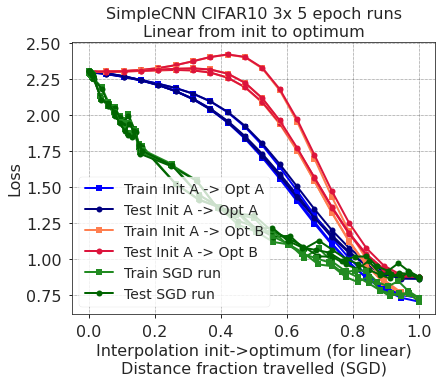

In [20]:
plt.figure(figsize = (6.5,5))

title = model_name+" "+dataset_choice+" "+str(points_to_collect)+"x "+str(epochs)+" epoch runs\n"
title = title+"Linear from init to optimum"

plt.title(title,fontsize = 16)


def add_line_to_plot(data = "test",label = None):

  if init_point_id == optimum_point_id:

    if data == "test":
      color = "navy"
    elif data == "train":
      color = "blue"

    linewidth = 2
  else:
    
    if data == "test":
      color = "crimson"
    elif data == "train":
      color = "coral"

    linewidth = 2

  if data == "test":
    data_to_show = interpolation_test_losses_list[init_point_id][optimum_point_id]
    alpha = 1.0
    marker = "o"
  elif data == "train":
    data_to_show = interpolation_train_losses_list[init_point_id][optimum_point_id]
    alpha = 1.0
    marker = "s"

  if label is None:
    label_str = "Init"+str(init_point_id)+"->"+"Opt"+str(optimum_point_id)
  else:
    label_str = label


  plt.plot(
      # interpolation_distance_from_init_list[init_point_id][optimum_point_id],
      ts,
      data_to_show,
      color = color,
      linewidth = linewidth,
      label = label_str,
      marker = marker,
      alpha = alpha,
      )


#the same to same
for init_point_id in range(points_to_collect):
  optimum_point_id = init_point_id

  if init_point_id == 0:
    label_train = "Train Init A -> Opt A"
    label_test = "Test Init A -> Opt A"
  else:
    label_train = ""
    label_test = ""

  add_line_to_plot("train",label_train)
  add_line_to_plot("test",label_test)

#different ones only
for init_point_id in range(points_to_collect):
  for optimum_point_id in range(init_point_id+1,points_to_collect):

    if ((init_point_id == 0) and (optimum_point_id == 1)):
      label_train = "Train Init A -> Opt B"
      label_test = "Test Init A -> Opt B"
    else:
      label_train = ""
      label_test = ""

    add_line_to_plot("train",label_train)
    add_line_to_plot("test",label_test)

#adding the optimized training
for point_id in range(points_to_collect):

  #train
  if point_id == 0:
     label = "Train SGD run"
  else:
    label = ""

  plt.plot(
      onp.array(distance_from_init_list[point_id])/distance_from_init_list[point_id][-1],
      train_losses_list[point_id],linewidth = 2,label = label,marker = "s",color = "forestgreen"
      )
  
  #train
  if point_id == 0:
     label = "Test SGD run"
  else:
    label = ""

  plt.plot(
      onp.array(distance_from_init_list[point_id])/distance_from_init_list[point_id][-1],
      test_losses_list[point_id],linewidth = 2,label = label,marker = "o",color = "darkgreen"
      )

plt.xticks(fontsize = 16) 
plt.yticks(fontsize = 16) 

# plt.xlabel("L2 weight distance travelled",fontsize = 16)
plt.xlabel("Interpolation init->optimum (for linear)\nDistance fraction travelled (SGD)",fontsize = 16)

plt.ylabel("Loss",fontsize = 16)

plt.legend(fontsize = 14)

plt.show()

# Nice plot

In [21]:
def make_subplot(x_type, y_type):

  if x_type == "L2" and y_type == "loss":
    title = "Loss vs L2 dist travelled"
  if x_type == "t" and y_type == "loss":
    title = "Loss vs fraction travelled"
  if x_type == "L2" and y_type == "acc":
    title = "Accuracy vs L2 dist travelled"
  if x_type == "t" and y_type == "acc":
    title = "Accuracy vs fraction travelled"

  plt.title(title,fontsize = 16)

  def add_line_to_plot(data = "test",label = None):

    if init_point_id == optimum_point_id:

      if data == "test":
        color = "navy"
      elif data == "train":
        color = "blue"

      linewidth = 2
    else:
      
      if data == "test":
        color = "crimson"
      elif data == "train":
        color = "coral"

      linewidth = 2

    if data == "test":

      if y_type == "loss":
        vals = interpolation_test_losses_list
      if y_type == "acc":
        vals = interpolation_test_accs_list

      data_to_show = vals[init_point_id][optimum_point_id]

      alpha = 1.0
      marker = "o"
    elif data == "train":

      if y_type == "loss":
        vals = interpolation_train_losses_list
      if y_type == "acc":
        vals = interpolation_train_accs_list

      data_to_show = vals[init_point_id][optimum_point_id]
      alpha = 1.0
      marker = "s"

    if label is None:
      label_str = "Init"+str(init_point_id)+"->"+"Opt"+str(optimum_point_id)
    else:
      label_str = label

    if x_type == "t":
      xs_vals = ts
    if x_type == "L2":
      xs_vals = interpolation_distance_from_init_list[init_point_id][optimum_point_id]

    plt.plot(
        xs_vals,
        data_to_show,
        color = color,
        linewidth = linewidth,
        label = label_str,
        marker = marker,
        alpha = alpha,
        )


  #the same to same
  for init_point_id in range(points_to_collect):
    optimum_point_id = init_point_id

    if init_point_id == 0:
      label_train = "Train Init A -> Opt A"
      label_test = "Test Init A -> Opt A"
    else:
      label_train = ""
      label_test = ""

    add_line_to_plot("train",label_train)
    add_line_to_plot("test",label_test)

  #different ones only
  for init_point_id in range(points_to_collect):
    for optimum_point_id in range(init_point_id+1,points_to_collect):

      if ((init_point_id == 0) and (optimum_point_id == 1)):
        label_train = "Train Init A -> Opt B"
        label_test = "Test Init A -> Opt B"
      else:
        label_train = ""
        label_test = ""

      add_line_to_plot("train",label_train)
      add_line_to_plot("test",label_test)

  #adding the optimized training
  for point_id in range(points_to_collect):

    #train
    if point_id == 0:
      label = "Train SGD run"
    else:
      label = ""

    if y_type == "loss":
      vals = train_losses_list[point_id]
    if y_type == "acc":
      vals = train_accs_list[point_id]

    if x_type == "t":
      x_vals = onp.array(distance_from_init_list[point_id])/distance_from_init_list[point_id][-1]
    if x_type == "L2":
      x_vals = onp.array(distance_from_init_list[point_id])


    plt.plot(
        x_vals,
        vals,linewidth = 2,label = label,marker = "s",color = "forestgreen"
        )
    
    #test
    if point_id == 0:
      label = "Test SGD run"
    else:
      label = ""

    if y_type == "loss":
      vals = test_losses_list[point_id]
    if y_type == "acc":
      vals = test_accs_list[point_id]

    if x_type == "t":
      x_vals = onp.array(distance_from_init_list[point_id])/distance_from_init_list[point_id][-1]
    if x_type == "L2":
      x_vals = onp.array(distance_from_init_list[point_id])

    plt.plot(
        x_vals,
        vals,linewidth = 2,label = label,marker = "o",color = "darkgreen"
        )

  plt.xticks(fontsize = 16) 
  plt.yticks(fontsize = 16) 

  # plt.xlabel("L2 weight distance travelled",fontsize = 16)
  if x_type == "t":
    plt.xlabel("Interpolation init->optimum (for linear)\nDistance fraction travelled (SGD)",fontsize = 16)
  if x_type == "L2":
    plt.xlabel("Distance init->optimum (for linear)\nDistance travelled (SGD)",fontsize = 16)

  if y_type == "loss":
    plt.ylabel("Loss",fontsize = 16)
  if y_type == "acc":
    plt.ylabel("Accuracy",fontsize = 16)

  plt.legend(fontsize = 14)


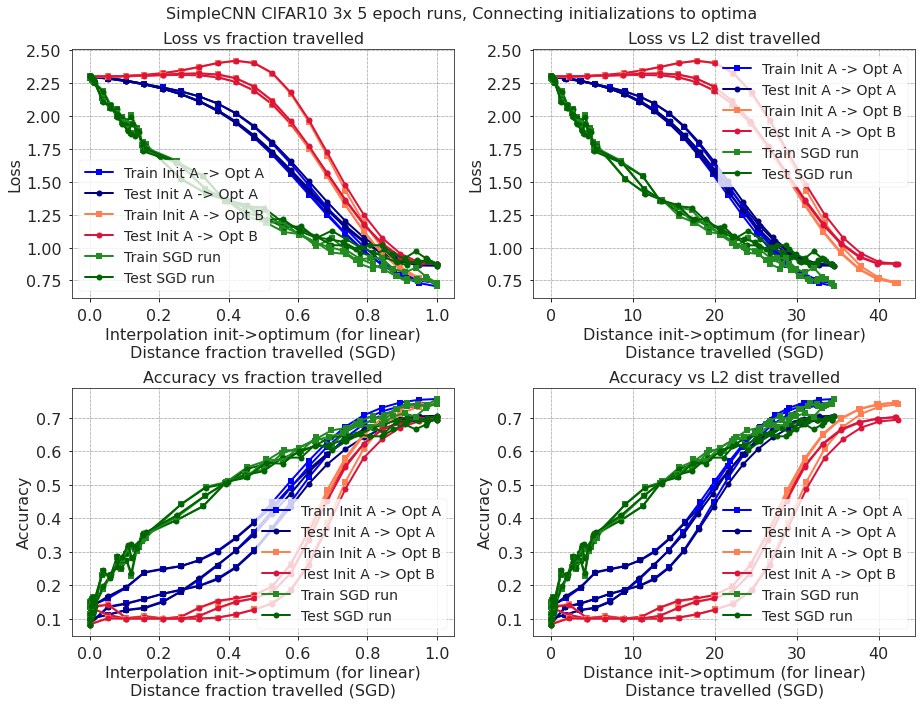

In [22]:
plt.figure(figsize = (2*6.5,2*5))

title = model_name+" "+dataset_choice+" "+str(points_to_collect)+"x "+str(epochs)+" epoch runs, Connecting initializations to optima"

plt.suptitle(title,fontsize = 16)

plt.subplot(2,2,1)
make_subplot("t","loss")

plt.subplot(2,2,2)
make_subplot("L2","loss")

plt.subplot(2,2,3)
make_subplot("t","acc")

plt.subplot(2,2,4)
make_subplot("L2","acc")

plt.tight_layout()

plt.subplots_adjust(top=0.92)

plt.show()


# A landscape cut -- 2 inits, 1 optimum

0 / 10


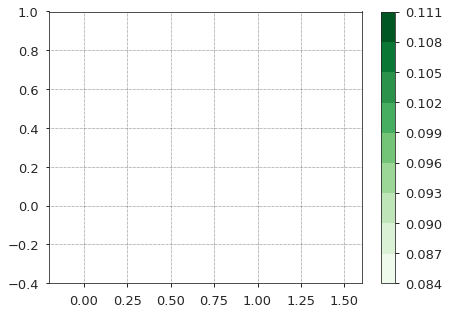

1 / 10


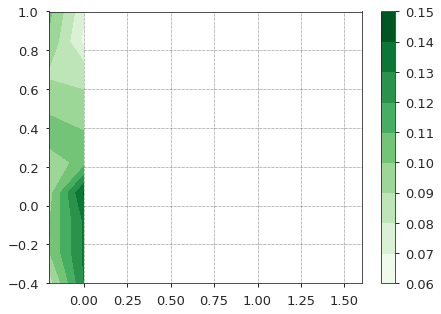

2 / 10


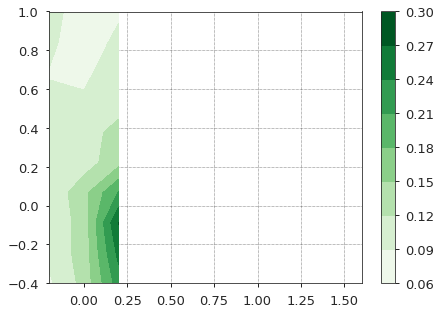

3 / 10


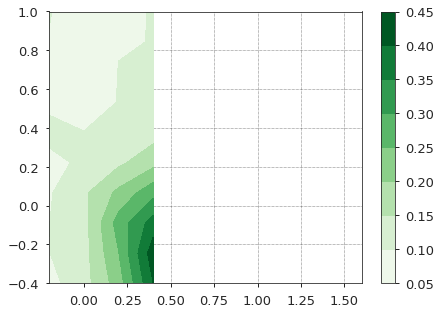

4 / 10


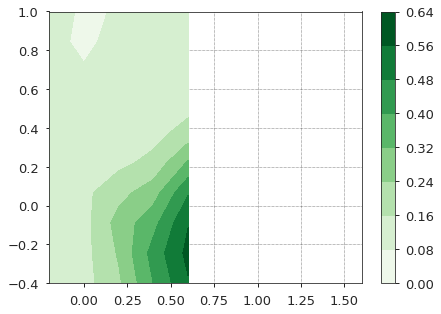

5 / 10


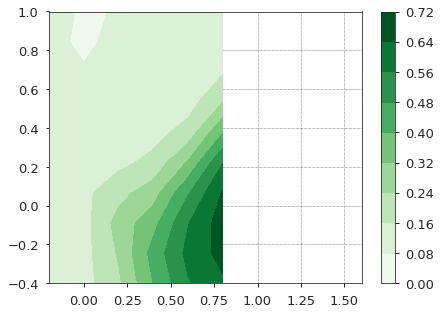

6 / 10


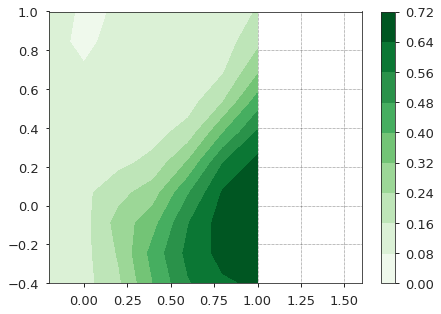

7 / 10


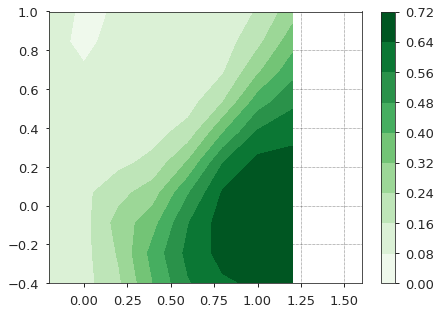

8 / 10


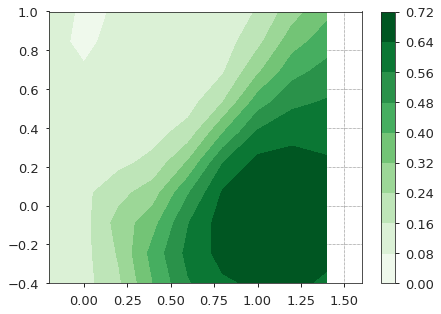

9 / 10


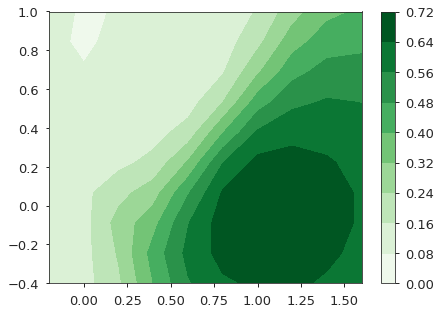

In [23]:
init1 = params_collected_by_iteration[0][0][1]
optimum1 = params_collected_by_iteration[0][-1][1]
init2 = params_collected_by_iteration[1][0][1]

point_start = init1

basis1 = linear_combine_trees(1.0,optimum1,-1.0,init1)
scale = tree_norm(basis1) 
basis1_normed = multiply_tree(1.0/tree_norm(basis1),basis1)

basis2 = linear_combine_trees(1.0,init2,-1.0,init1)
basis2 = linear_combine_trees(1.0,basis2,-1.0*dot_trees(basis2,basis1_normed),basis1_normed)
basis2_normed = multiply_tree(1.0/tree_norm(basis2),basis2)

xs = onp.linspace(-0.2,1.6,10)
ys = onp.linspace(-0.4,1.0,10)

test_loss_grid = onp.zeros((len(xs),len(ys)))*float("NaN")
test_accs_grid = onp.zeros((len(xs),len(ys)))*float("NaN")

train_loss_grid = onp.zeros((len(xs),len(ys)))*float("NaN")
train_accs_grid = onp.zeros((len(xs),len(ys)))*float("NaN")

for ix,x in enumerate(xs):
  for iy,y in enumerate(ys):
    params_now = linear_combine_trees(1.0,point_start,1.0,linear_combine_trees(x*scale,basis1_normed,y*scale,basis2_normed))

    test_loss_now,test_acc_now = normal_loss_and_accuracy(params_now,test_ds,True,5000)
    test_loss_grid[ix,iy] = test_loss_now
    test_accs_grid[ix,iy] = test_acc_now

    train_loss_now,train_acc_now = normal_loss_and_accuracy(params_now,{"image": train_ds["image"][:5000],"onehot":train_ds["onehot"][:5000]},True,5000) 
    train_loss_grid[ix,iy] = train_loss_now
    train_accs_grid[ix,iy] = train_acc_now

  print(ix,"/",len(xs))

  plt.contourf(xs,ys,test_accs_grid.T,cmap = plt.cm.Greens)
  plt.colorbar()
  plt.show()


In [24]:
def project_params(params_now):
  diff = linear_combine_trees(1.0,params_now,-1.0,point_start)
  x_val = dot_trees(diff,basis1_normed)/scale
  y_val = dot_trees(diff,basis2_normed)/scale
  return x_val,y_val

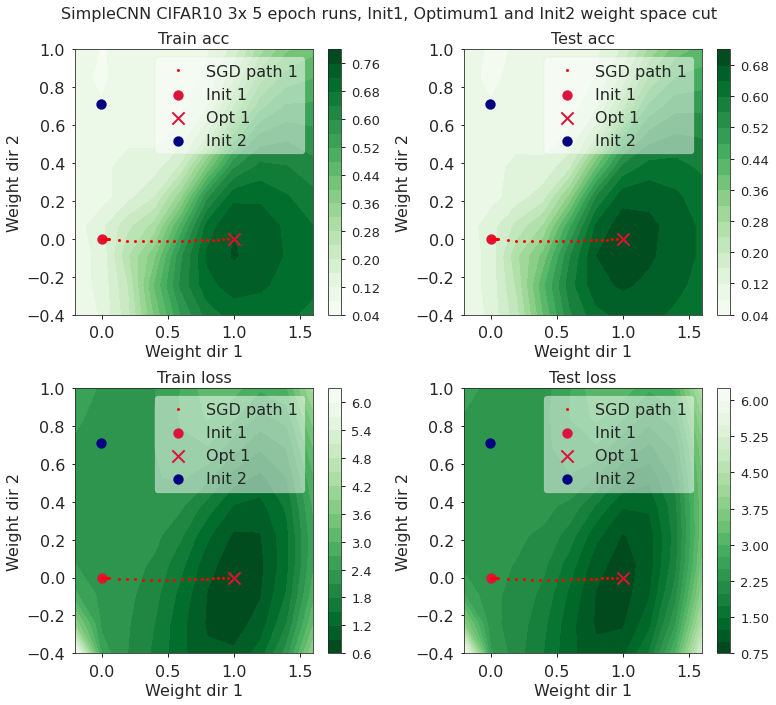

In [25]:
xs_path = []
ys_path = []
for i in range(0,len(params_collected_by_iteration[0]),1):
  x_val,y_val = project_params(params_collected_by_iteration[0][i][1])
  xs_path.append(x_val)
  ys_path.append(y_val)

def make_subplot(data_to_show,title = "",inverse = False):

  if inverse:
    cmap = plt.cm.Greens_r
  else:
    cmap = plt.cm.Greens

  plt.title(title,fontsize = 16)
  plt.contourf(xs,ys,data_to_show,cmap = cmap,levels = 20)
  plt.colorbar()

  x_val,y_val = project_params(init1)
  plt.scatter([x_val],[y_val],marker = "o",s=100,label = "Init 1",color = "crimson")

  x_val,y_val = project_params(optimum1)
  plt.scatter([x_val],[y_val],marker = "x",s=150,label = "Opt 1",color = "crimson")


  plt.plot(xs_path,ys_path,marker = "o",color = "red",markersize = 3,linestyle = "",label = "SGD path 1")

  x_val,y_val = project_params(init2)
  plt.scatter([x_val],[y_val],marker = "o",s=100,label = "Init 2",color = "navy")

  plt.xlabel("Weight dir 1",fontsize = 16)
  plt.ylabel("Weight dir 2",fontsize = 16)

  plt.xticks(fontsize = 16) 
  plt.yticks(fontsize = 16) 

  plt.legend(fontsize = 16,framealpha = 0.5)


plt.figure(figsize = (2*5.5,2*5.0))

title = model_name+" "+dataset_choice+" "+str(points_to_collect)+"x "+str(epochs)+" epoch runs, Init1, Optimum1 and Init2 weight space cut"

plt.suptitle(title,fontsize = 16)

plt.subplot(2,2,1)
make_subplot(train_accs_grid.T,"Train acc")

plt.subplot(2,2,2)
make_subplot(test_accs_grid.T,"Test acc")

plt.subplot(2,2,3)
make_subplot(train_loss_grid.T,"Train loss",inverse = True)

plt.subplot(2,2,4)
make_subplot(test_loss_grid.T,"Test loss", inverse = True)

plt.tight_layout()

plt.subplots_adjust(top=0.92)

plt.show()

# A landscape cut -- 1 init, 2 optima

0 / 10


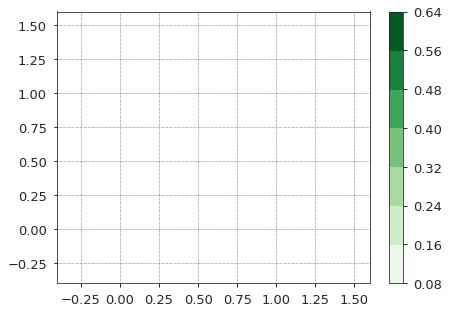

1 / 10


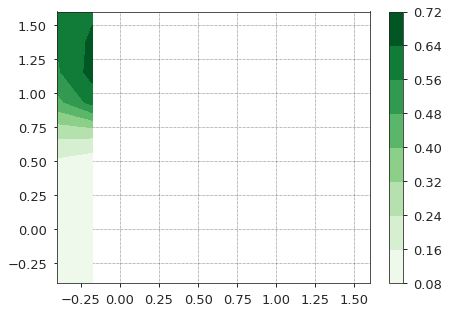

2 / 10


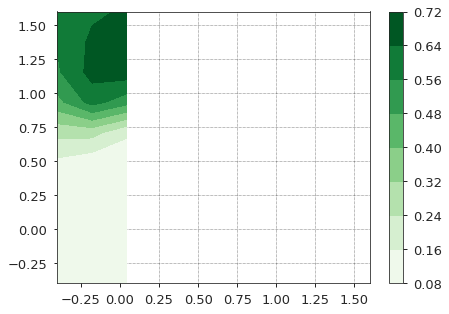

3 / 10


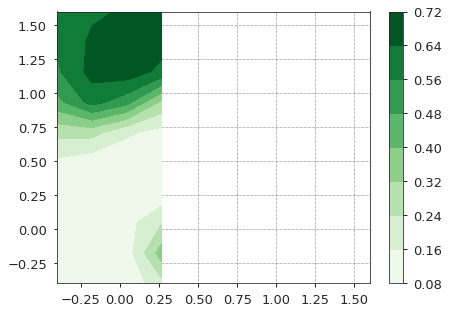

4 / 10


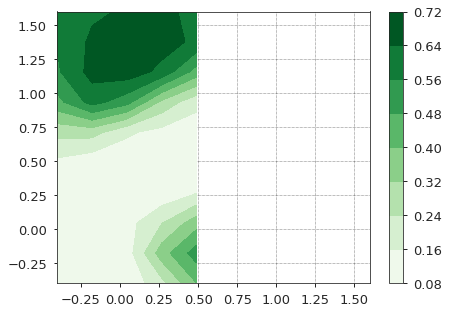

5 / 10


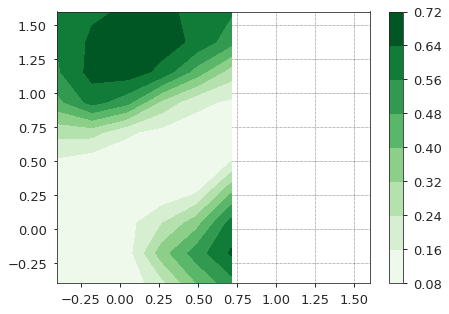

6 / 10


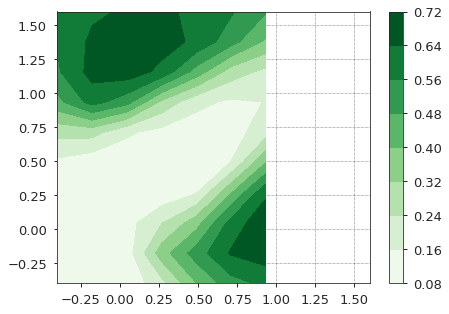

7 / 10


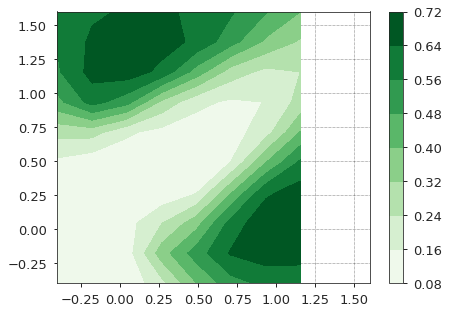

8 / 10


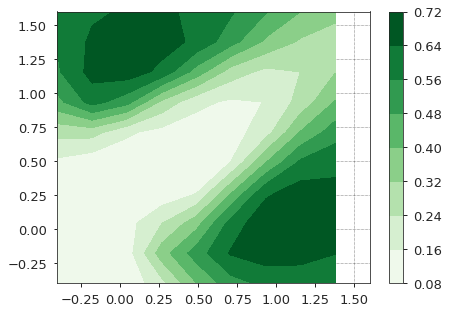

9 / 10


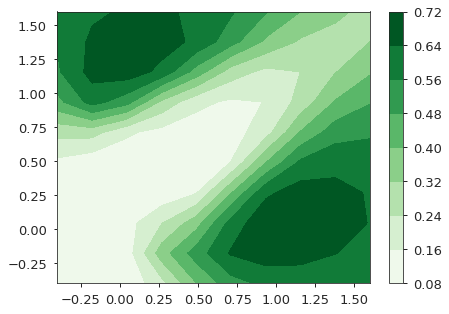

In [28]:
init1 = params_collected_by_iteration[0][0][1]
optimum1 = params_collected_by_iteration[0][-1][1]
optimum2 = params_collected_by_iteration[1][-1][1]

point_start = init1

basis1 = linear_combine_trees(1.0,optimum1,-1.0,init1)
scale = tree_norm(basis1) 
basis1_normed = multiply_tree(1.0/tree_norm(basis1),basis1)

basis2 = linear_combine_trees(1.0,optimum2,-1.0,init1)
basis2 = linear_combine_trees(1.0,basis2,-1.0*dot_trees(basis2,basis1_normed),basis1_normed)
basis2_normed = multiply_tree(1.0/tree_norm(basis2),basis2)

xs = onp.linspace(-0.4,1.6,10)
ys = onp.linspace(-0.4,1.6,10)

test_loss_grid = onp.zeros((len(xs),len(ys)))*float("NaN")
test_accs_grid = onp.zeros((len(xs),len(ys)))*float("NaN")

train_loss_grid = onp.zeros((len(xs),len(ys)))*float("NaN")
train_accs_grid = onp.zeros((len(xs),len(ys)))*float("NaN")

for ix,x in enumerate(xs):
  for iy,y in enumerate(ys):
    params_now = linear_combine_trees(1.0,point_start,1.0,linear_combine_trees(x*scale,basis1_normed,y*scale,basis2_normed))

    test_loss_now,test_acc_now = normal_loss_and_accuracy(params_now,test_ds,True,5000)
    test_loss_grid[ix,iy] = test_loss_now
    test_accs_grid[ix,iy] = test_acc_now

    train_loss_now,train_acc_now = normal_loss_and_accuracy(params_now,{"image": train_ds["image"][:5000],"onehot":train_ds["onehot"][:5000]},True,5000) 
    train_loss_grid[ix,iy] = train_loss_now
    train_accs_grid[ix,iy] = train_acc_now

  print(ix,"/",len(xs))

  plt.contourf(xs,ys,test_accs_grid.T,cmap = plt.cm.Greens)
  plt.colorbar()
  plt.show()


In [29]:
def project_params(params_now):
  diff = linear_combine_trees(1.0,params_now,-1.0,point_start)
  x_val = dot_trees(diff,basis1_normed)/scale
  y_val = dot_trees(diff,basis2_normed)/scale
  return x_val,y_val

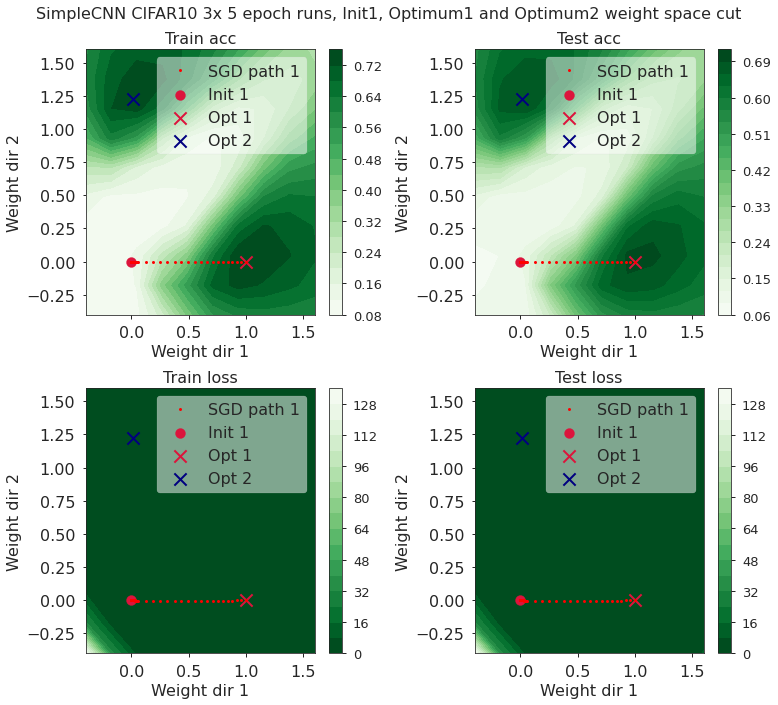

In [30]:
xs_path = []
ys_path = []
for i in range(0,len(params_collected_by_iteration[0]),1):
  x_val,y_val = project_params(params_collected_by_iteration[0][i][1])
  xs_path.append(x_val)
  ys_path.append(y_val)

def make_subplot(data_to_show,title = "",inverse = False):

  if inverse:
    cmap = plt.cm.Greens_r
  else:
    cmap = plt.cm.Greens

  plt.title(title,fontsize = 16)
  plt.contourf(xs,ys,data_to_show,cmap = cmap,levels = 20)
  plt.colorbar()

  x_val,y_val = project_params(init1)
  plt.scatter([x_val],[y_val],marker = "o",s=100,label = "Init 1",color = "crimson")

  x_val,y_val = project_params(optimum1)
  plt.scatter([x_val],[y_val],marker = "x",s=150,label = "Opt 1",color = "crimson")


  plt.plot(xs_path,ys_path,marker = "o",color = "red",markersize = 3,linestyle = "",label = "SGD path 1")

  x_val,y_val = project_params(optimum2)
  plt.scatter([x_val],[y_val],marker = "x",s=150,label = "Opt 2",color = "navy")

  plt.xlabel("Weight dir 1",fontsize = 16)
  plt.ylabel("Weight dir 2",fontsize = 16)

  plt.xticks(fontsize = 16) 
  plt.yticks(fontsize = 16) 

  plt.legend(fontsize = 16,framealpha = 0.5)


plt.figure(figsize = (2*5.5,2*5.0))

title = model_name+" "+dataset_choice+" "+str(points_to_collect)+"x "+str(epochs)+" epoch runs, Init1, Optimum1 and Optimum2 weight space cut"

plt.suptitle(title,fontsize = 16)

plt.subplot(2,2,1)
make_subplot(train_accs_grid.T,"Train acc")

plt.subplot(2,2,2)
make_subplot(test_accs_grid.T,"Test acc")

plt.subplot(2,2,3)
make_subplot(train_loss_grid.T,"Train loss",inverse = True)

plt.subplot(2,2,4)
make_subplot(test_loss_grid.T,"Test loss", inverse = True)

plt.tight_layout()

plt.subplots_adjust(top=0.92)

plt.show()